### Load Model Samples

In [1]:
print("strawberry")

# loss function and metrics
from trustworthai.utils.losses_and_metrics.dice_loss import DiceLossWithWeightedEmptySlices
from trustworthai.utils.losses_and_metrics.dice_loss_metric import DiceLossMetric, SsnDiceMeanMetricWrapper

# predefined training dataset
from trustworthai.utils.data_preprep.dataset_pipelines import load_data
from torch.utils.data import ConcatDataset

# fitter
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.fitters.p_unet_fitter import PUNetLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# model
from trustworthai.run.model_load.load_ssn import load_ssn
from trustworthai.run.model_load.load_punet import load_p_unet
from trustworthai.run.model_load.load_deterministic import load_deterministic
from trustworthai.models.stochastic_wrappers.ssn.LowRankMVCustom import LowRankMultivariateNormalCustom
from trustworthai.models.stochastic_wrappers.ssn.ReshapedDistribution import ReshapedDistribution

# optimizer and lr scheduler
import torch

# misc
import argparse
import os
import shutil
import shlex
from collections import defaultdict
from tqdm import tqdm
import sys
from natsort import natsorted

print("banana")

strawberry
banana


In [2]:
from trustworthai.utils.data_preprep.dataset_pipelines import load_clinscores_data, load_data, ClinScoreDataRetriever

In [3]:
models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"

In [4]:
def construct_parser():
    parser = argparse.ArgumentParser(description = "train models")
    
    # folder arguments
    parser.add_argument('--ckpt_dir', default='s2208943/results/revamped_models/', type=str)
    parser.add_argument('--model_name', default=None, type=str)
    
    # data generation arguments
    parser.add_argument('--dataset', default='ed', type=str)
    parser.add_argument('--seed', default=3407, type=int)
    parser.add_argument('--test_split', default=0.15, type=float)
    parser.add_argument('--val_split', default=0.15, type=float)
    parser.add_argument('--empty_slice_retention', default=0.1, type=float)
    
    # model specific parameters SSN
    parser.add_argument('--ssn_rank', default=15, type=int)
    parser.add_argument('--ssn_epsilon', default=1e-5, type=float)
    parser.add_argument('--ssn_mc_samples', default=10, type=int)
    parser.add_argument('--ssn_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--ssn_pre_head_layers', default=16, type=int)
    
    # evidential loss parameters
    parser.add_argument('--kl_factor', default=0.1, type=float)
    parser.add_argument('--kl_anneal_count', default=452*4, type=int)
    
     # model specific parameters Punet
    parser.add_argument('--kl_beta', default=10.0, type=float)
    parser.add_argument('--use_prior_for_dice', default=False, type=bool)
    parser.add_argument('--punet_sample_dice_coeff', default=0.05, type=float)
    parser.add_argument('--latent_dim', default=12, type=int)
    
    # general arguments for the loss function
    parser.add_argument('--dice_factor', default=5, type=float)
    parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    
    # general arguments for the loss function
    parser.add_argument('--loss_name', default='dice+xent', type=str)
    # parser.add_argument('--dice_factor', default=5, type=float)
    # parser.add_argument('--xent_factor', default=0.01, type=float)
    parser.add_argument('--xent_weight', default='none', type=str)
    #parser.add_argument('--dice_empty_slice_weight', default=0.5, type=float)
    parser.add_argument('--tversky_beta', default=0.7, type=float)
    parser.add_argument('--reduction', default='mean_sum', type=str)
    
    # training paradigm arguments
    parser.add_argument('--lr', default=2e-4, type=float)
    parser.add_argument('--dropout_p', default=0.0, type=float)
    parser.add_argument('--max_epochs', default=100, type=int)
    parser.add_argument('--early_stop_patience', default=15, type=int)
    parser.add_argument('--batch_size', default=32, type=int)
    parser.add_argument('--cross_validate', default=False, type=bool)
    parser.add_argument('--cv_split', default=0, type=int)
    parser.add_argument('--cv_test_fold_smooth', default=1, type=int)
    parser.add_argument('--weight_decay', default=0.0001, type=float)
    parser.add_argument('--overwrite', default=False, type=bool)
    
    return parser

In [5]:
def load_best_checkpoint(model, loss, model_ckpt_folder, punet=False):
    # this is ultimately going to need to be passed a model wrapper when I implement P-Unet....
    
    # the path to the best checkpoint is stored as a single line in a txt file along with each model
    with open(os.path.join(model_ckpt_folder, "best_ckpt.txt"), "r") as f:
        ckpt_file = os.path.join(model_ckpt_folder, f.readlines()[0][:-1].split("/")[-1])
    
    if punet:
        return PUNetLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)
    return StandardLitModelWrapper.load_from_checkpoint(ckpt_file, model=model, loss=loss, 
                                    logging_metric=lambda : None)

In [10]:
def entropy_map_from_mean(mean, do_normalize=True):
    "samples is of shape samples, batch size, channels, image dims  [s, b, c *<dims>]"
    if mean.shape[1] == 1:
        raise ValueError("not implemented for implicit background class")
    else:
        assert mean.shape[1] == 2
    
    if do_normalize:
        probs = torch.nn.functional.softmax(mean, dim=1)
    else:
        probs = mean
    ent_map = torch.sum(-probs * torch.log(probs+1e-30), dim=1)

    return ent_map

In [7]:
def generate_means_and_samples_SSN_Ens(splits=6, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False):
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_cross_validate_32_"

    model_outs = defaultdict(lambda : defaultdict(lambda : {'means':[], 'samples':[]}))

    test_datasets = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.15,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        for ens in range(10):
            model_name = model_base_name + f"split{split}_ens{ens}/"
            model_path = models_folder + model_name

            # with open(model_path + "best_ckpt.txt") as f:
            #     lines = f.readlines()
            #     args_lines = [l[:-1].split(": ") for l in lines[1:]]
            #     args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            #     args_line = " ".join(args_lines)
            #     parser = construct_parser()
            #     args = parser.parse_args(shlex.split(args_line))

            # load the model
            model = load_best_checkpoint(model_raw, loss, model_path)
            model.eval()


            dataskip = dataset_stride
            # means = []
            # samples = []
            for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
                if i % dataskip == 0:
                    x = data[0]
                    with torch.no_grad():
                        mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples // 10, temperature=temp, symmetric=False)

                        model_outs[split][i]['means'].append(mean.cpu())
                        model_outs[split][i]['samples'].append(sample.cpu())

    for split in model_outs.keys():
        for idx in tqdm(model_outs[split].keys(), position=0, leave=True):
            model_outs[split][idx]['means'] = torch.stack(model_outs[split][idx]['means'], dim=0).mean(dim=0)
            model_outs[split][idx]['samples'] = torch.cat(model_outs[split][idx]['samples'], dim=0)

    means = [model_outs[split][idx]['means'] for split in model_outs.keys() for idx in model_outs[split].keys()]
    samples = [model_outs[split][idx]['samples'] for split in model_outs.keys() for idx in model_outs[split].keys()]

    return means, samples, ConcatDataset(test_datasets)

In [8]:
def generate_means_and_samples_SSN_Ens_Efficient(splits=6, dataset_stride=2, temp=1, num_samples=10, use_updated_scores=False):
    # load data
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    
    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    
    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_cross_validate_32_"

    means = []
    samples = []

    test_datasets = []

    for split in range(splits):
        model_outs = defaultdict(lambda : {'means':[], 'samples':[]})
        
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.15,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
            
        )
        test_datasets.append(test_ds_clin)
        print("size: ", len(test_ds_clin))


        for ens in range(10):
            model_name = model_base_name + f"split{split}_ens{ens}/"
            model_path = models_folder + model_name

            # with open(model_path + "best_ckpt.txt") as f:
            #     lines = f.readlines()
            #     args_lines = [l[:-1].split(": ") for l in lines[1:]]
            #     args_lines = [f'--{l[0]} {l[1]}' for l in args_lines]
            #     args_line = " ".join(args_lines)
            #     parser = construct_parser()
            #     args = parser.parse_args(shlex.split(args_line))

            # load the model
            model = load_best_checkpoint(model_raw, loss, model_path)
            model.eval()


            dataskip = dataset_stride
            # means = []
            # samples = []
            for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
                if i % dataskip == 0:
                    x = data[0]
                    with torch.no_grad():
                        mean, sample = model.mean_and_sample(x.swapaxes(0,1).cuda(), num_samples=num_samples // 10, temperature=temp, symmetric=False)

                        model_outs[i]['means'].append(mean.cpu())
                        model_outs[i]['samples'].append(sample.cpu())

        for idx in tqdm(model_outs.keys(), position=0, leave=True):
            means.append(torch.stack(model_outs[idx]['means'], dim=0).mean(dim=0))
            samples.append(torch.cat(model_outs[idx]['samples'], dim=0))

    return means, samples, ConcatDataset(test_datasets)

In [9]:
def generate_means_and_samples_SSN_Ens_Mean(splits=6, dataset_stride=2, temp=1, num_samples=10, components=10, use_updated_scores=False):
    # load data
    print("loading")
    clin_retriever = ClinScoreDataRetriever(use_updated_scores=use_updated_scores)
    print("loaded")
    
    test_datasets = []

    # load model
    class TestArgs():
        def __init__(self, ):
            args_dict = {
                "dropout_p":0,
                "ssn_pre_head_layers":32,
                "ssn_rank":15,
                "ssn_epsilon":1e-5,
                "dice_empty_slice_weight":0.5,
                "ssn_mc_samples":10,
                "dice_factor":5,
                "xent_factor":0.01,
                "ssn_sample_dice_coeff":0.05
            }

            for key, value in args_dict.items():
                setattr(self, key, value)

    args = TestArgs()

    model_raw, loss = load_ssn(args)
    model_raw = model_raw.cuda()
    model_raw.return_cpu_dist = True

    models_folder = "/home/s2208943/ipdis/results/cross_validated_models/"
    #model_names = os.listdir(models_folder)

    model_base_name = "ssn_cross_validate_32_"

    means = []
    samples = []

    for split in range(splits):
        # load specific data split
        train_ds_clin, val_ds_clin, test_ds_clin = clin_retriever.load_clinscores_data(
            combine_all=False,
            test_proportion=0.15, 
            validation_proportion=0.12,
            seed=3407,
            cross_validate=True,
            cv_split=split,
            cv_test_fold_smooth=1,
        )
        test_datasets.append(test_ds_clin)
        # print("size: ", len(test_ds_clin))

        dataskip = dataset_stride

        for i, data in enumerate(tqdm(test_ds_clin, position=0, leave=True)):
            if i % dataskip == 0:
                x = data[0].swapaxes(0,1).cuda()
                distribution_means = []
                distribution_cov_diags = []
                distribution_cov_factors = []
                distribution_event_shapes = []

                for ens in range(components):
                    # print(ens)
                    model_name = model_base_name + f"split{split}_ens{ens}/"
                    model_path = models_folder + model_name
                    model = load_best_checkpoint(model_raw, loss, model_path)
                    model.eval()

                    with torch.no_grad():
                        mean, cov_diag, cov_factor, event_shape = model(x)
                    distribution_means.append(mean.cpu())
                    distribution_cov_diags.append(cov_diag.cpu())
                    distribution_cov_factors.append(cov_factor.cpu())
                    distribution_event_shapes.append(event_shape)

                # print(distribution_means[0].shape)

                distribution_means = torch.stack(distribution_means, dim=0).mean(dim=0)
                distribution_cov_diags = torch.stack(distribution_cov_diags, dim=0).mean(dim=0)
                distribution_cov_factors = torch.stack(distribution_cov_factors, dim=0).mean(dim=0)

                # print(distribution_means.shape)

                dist = LowRankMultivariateNormalCustom(distribution_means, distribution_cov_factors, distribution_cov_diags)
                dist = ReshapedDistribution(dist, distribution_event_shapes[0])

                means.append((dist.mean / temp).cpu())
                samples.append((model_raw._samples_from_dist(dist, num_samples=num_samples)/temp).cpu())

    return means, samples, ConcatDataset(test_datasets)

In [9]:
import matplotlib.pyplot as plt
from trustworthai.utils.uncertainty_maps.entropy_map import entropy_map_from_samples
from trustworthai.utils.plotting.saving_plots import save, imsave
from trustworthai.utils.print_and_write_func import print_and_write
import pandas as pd

In [10]:
#samples[0].shape

In [11]:
stride = 1

In [ ]:
means, samples, test_datasets = generate_means_and_samples_SSN_Ens_Efficient(splits=6, dataset_stride=stride, temp=1, num_samples=10, use_updated_scores=False)

In [ ]:
# softmax entropy
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=True) for scan_index in range(len(means))]

# evidential
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=False) for scan_index in range(len(means))]

# other methods
ent_maps = [entropy_map_from_samples(samples[scan_index]) for scan_index in range(len(means))]

In [ ]:
len(test_datasets), len(test_datasets[0])

In [ ]:
scan_id = 0
islice = 20
plt.subplot(1,3,1)
plt.imshow(ent_maps[scan_id][islice]); plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(means[scan_id][islice].argmax(dim=0)); plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(test_datasets[scan_id][1][0][islice]); plt.axis('off')

In [ ]:
def fast_dice(pred, target):
    p1 = (pred == 1)
    t1 = (target == 1)
    intersection = (pred == 1) & (target == 1)
    numerator = 2 * intersection.sum()
    denominator = p1.sum() + t1.sum()
    return (numerator/(denominator + 1e-30)).item()


In [ ]:
means[0].shape

In [ ]:
dices = []
for i in tqdm(range(len(means)), position=0, leave=True):
    pred = means[i].cuda().argmax(dim=1)
    target = test_datasets[i][1][0].cuda()
    dices.append(fast_dice(pred, target))

In [ ]:
f_dices = [d for d in dices if d > 0.01]

In [ ]:
#f_dices

In [ ]:
torch.Tensor(f_dices).mean()

In [14]:
len(means), len(samples)

(250, 250)

In [ ]:
# softmax entropy
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=True) for scan_index in range(len(means))]

# evidential
# ent_maps = [entropy_map_from_mean(means[scan_index], do_normalize=False) for scan_index in range(len(means))]

# other methods
ent_maps = [entropy_map_from_samples(samples[scan_index]) for scan_index in range(len(means))]

In [16]:
def var_map_from_samples(samples):
    samples = torch.softmax(samples.cuda(), dim=2)[:,:,1]
    return torch.var(samples, dim=0).cpu()

In [17]:
var_maps = [var_map_from_samples(samples[scan_index]) for scan_index in tqdm(range(len(means)), position=0, leave=True)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:11<00:00, 21.37it/s]


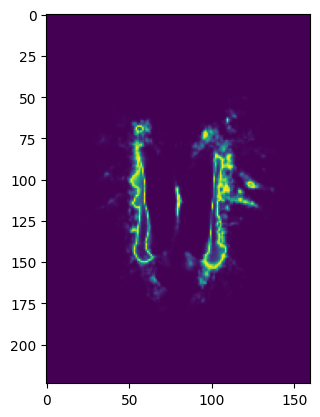

In [18]:
plt.imshow(entropy_map_from_samples(samples[0])[25])

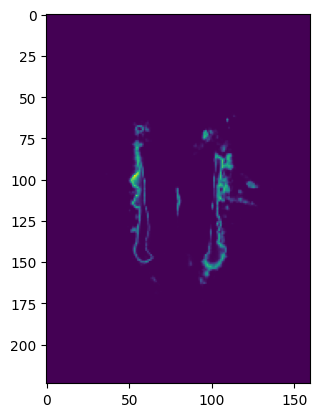

In [19]:
plt.imshow(var_maps[0][25])

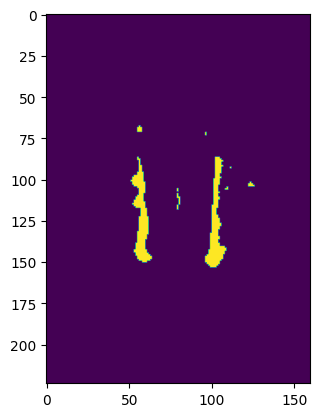

In [21]:
plt.imshow((torch.nn.functional.softmax(means[0], dim=1))[:,1][25] > 0.5)

In [ ]:
len(test_datasets), len(test_datasets[0])

In [23]:
xs3d_test = []
ys3d_test = []
IDs = []
clin_values = []

for i, data in enumerate(test_datasets):
    if i % stride == 0:
        ys3d_test.append(data[1].squeeze())
        xs3d_test.append(data[0])
        IDs.append(data[-1]['ID'])
        clin_values.append(data[-1])

In [24]:
clin_values = pd.DataFrame.from_records(clin_values)

In [25]:
clin_values

,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,...,WMH,PVWMH,DWMH,deepAtrophy,supAtrophy,BGPVS,CSPVS,relLes,oldLes,micrBld
0,107,CVD152,1,81.0,1,0,1,1.0,1.0,170.0,...,27.970046,2.0,1.0,6.0,2.0,3.0,2.0,1.0,0.0,1.0
1,16,CVD023,1,74.0,1,1,1,0.0,1.0,123.0,...,22.021616,3.0,2.0,4.0,4.0,3.0,2.0,1.0,1.0,0.0
2,4,CVD008,1,50.0,2,0,1,0.0,2.0,196.0,...,56.672922,2.0,3.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0
3,100,CVD141,1,83.0,1,0,1,1.0,0.0,128.0,...,9.200202,1.0,1.0,4.0,2.0,1.0,0.0,1.0,0.0,0.0
4,31,CVD041,1,77.0,1,1,1,0.0,0.0,137.0,...,71.247656,3.0,3.0,6.0,2.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,213,CVD289,1,81.0,2,1,1,1.0,0.0,158.0,...,4.682812,2.0,2.0,4.0,2.0,2.0,2.0,0.0,0.0,0.0
246,242,CVD318,1,72.0,1,0,1,0.0,2.0,138.0,...,27.664453,3.0,2.0,5.0,2.0,2.0,3.0,1.0,1.0,1.0
247,226,CVD302,1,55.0,1,0,1,0.0,2.0,150.0,...,1.518750,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,0.0
248,203,CVD279,1,63.0,1,1,1,0.0,1.0,146.0,...,1.817578,1.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0


In [26]:
output_dir = "/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/"
model_name = "SSN_Ens"

if len(os.listdir(output_dir + model_name)) > 0:
    raise ValueError("directory is not empty")
else:
    print("good, empty folder")

good, empty folder


In [27]:
import numpy as np

In [28]:
for i in tqdm(range(len(IDs)), position=0, leave=True):
    ID = IDs[i]
    var = var_maps[i]
    ent = ent_maps[i]
    pred = torch.nn.functional.softmax(means[i].cuda(), dim=1)[:,1]
    seg = (pred > 0.5)
    np.savez_compressed(f"{output_dir}{model_name}/{ID}_out_maps.npz", var=var, ent=ent, pred=pred.cpu(), seg=seg.cpu())
    

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [07:31<00:00,  1.81s/it]


In [29]:
len(os.listdir(output_dir + model_name))

250

In [30]:
example = np.load(f"{output_dir}{model_name}/{'CVD152'}_out_maps.npz")

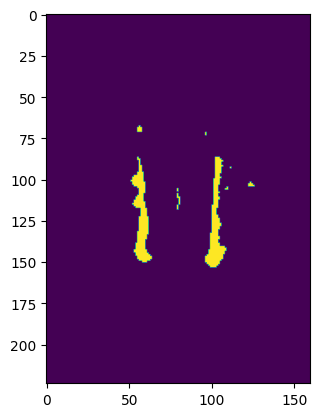

In [34]:
plt.imshow(example['seg'][25])